# Generative Adversarial Networks in Keras

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

Using TensorFlow backend.


## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [3]:
n = len(X_train)

In [4]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [5]:
X_train /= 255.; X_test /= 255.

## Train

This is just a helper to plot a bunch of generated images.

In [6]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

Create some random data for the generator.

In [7]:
def noise(bs): return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [8]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz  # D should predict 1 for data generated by G, 0 for real data

In [9]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [10]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        # - adding the following recompile would avoid Keras 2.1 warning at training start
        # - but would make training very slow
        #m.compile(Adam(1e-4), "binary_crossentropy")
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl,gl

## MLP GAN

We'll keep thinks simple by making D & G plain ole' MLPs.

In [11]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [12]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [13]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [14]:
dl,gl = train(MLP_D, MLP_G, MLP_m, 8000)

  0%|          | 0/8000 [00:00<?, ?it/s]/home/roebius/anaconda/envs/f1/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 8000/8000 [01:01<00:00, 130.17it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

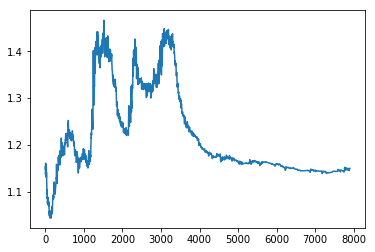

In [15]:
plt.plot(dl[100:])

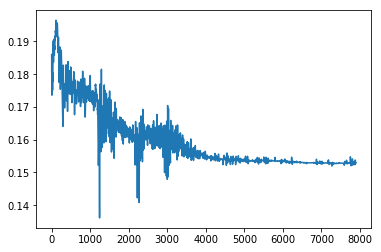

In [16]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

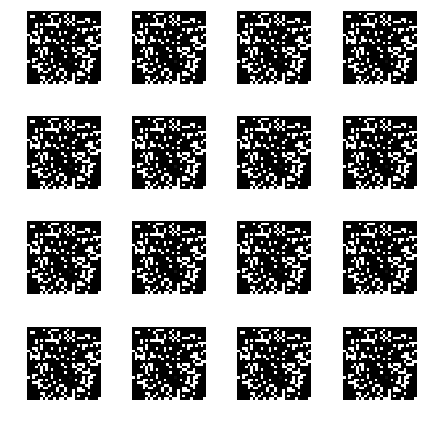

In [17]:
plot_gen(MLP_G)

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Add see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [18]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [19]:
# Keras 2
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100),
    advanced_activations.LeakyReLU(),  # alpha=0.3 default
    BatchNormalization(),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Conv2D(64, (3, 3), padding='same'),
    advanced_activations.LeakyReLU(),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(32, (3, 3), padding='same'),
    advanced_activations.LeakyReLU(),
    BatchNormalization(),
    Conv2D(1, (1, 1), padding='same', activation='sigmoid')
])

The discriminator uses a few downsampling steps through strided convolutions.

In [20]:
# Keras 2
CNN_D = Sequential([
    Conv2D(256, (5, 5), strides=(2,2), padding='same', 
                  input_shape=(28, 28, 1)),
    advanced_activations.LeakyReLU(),
    Conv2D(512, (5, 5), strides=(2,2), padding='same'),
    advanced_activations.LeakyReLU(),
    Flatten(),
    Dense(256),
    advanced_activations.LeakyReLU(),
    Dense(1, activation = 'sigmoid')
])

CNN_D.compile(Adam(1e-3), "binary_crossentropy")

We train D a "little bit" so it can at least tell a real image from random noise.

In [21]:
sz = n//200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, epochs=1, verbose=2)

Epoch 1/1
 - 1s - loss: 1.1130


In [22]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [23]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively.

In [24]:
dl,gl = train(CNN_D, CNN_G, CNN_m, 2500)

  0%|          | 0/2500 [00:00<?, ?it/s]/home/roebius/anaconda/envs/f1/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [03:42<00:00, 11.22it/s]


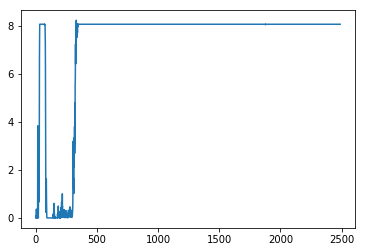

In [25]:
plt.plot(dl[10:])

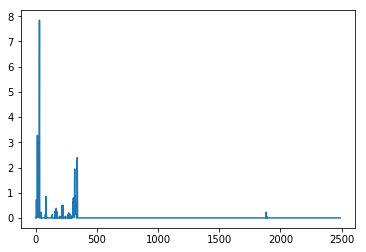

In [26]:
plt.plot(gl[10:])

Better than our first effort, but still a lot to be desired:...

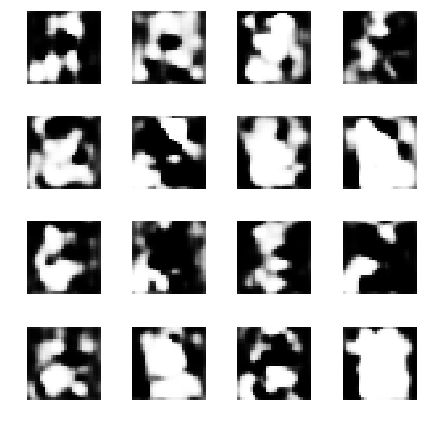

In [27]:
plot_gen(CNN_G)

## End